In [8]:
%cd GPT-2-from-scratch/

/content/GPT-2-from-scratch


Initial GPU memory allocated: 0.00 GB
Initial GPU memory reserved: 0.00 GB
Epoch 1, Step 0: Train Loss: 2.5380, Val Loss: 2.6092
Saved best model with val loss: 2.6092
Epoch 1, Step 100: Train Loss: 2.4070, Val Loss: 2.3706
Saved best model with val loss: 2.3706
Epoch 1, Step 200: Train Loss: 2.1781, Val Loss: 2.2687
Saved best model with val loss: 2.2687
Epoch 1, Step 300: Train Loss: 2.0456, Val Loss: 2.2667
Saved best model with val loss: 2.2667
Epoch 1, Step 400: Train Loss: 1.9201, Val Loss: 2.2595
Saved best model with val loss: 2.2595
Epoch 1, Step 500: Train Loss: 2.1172, Val Loss: 2.2396
Saved best model with val loss: 2.2396
Epoch 1, Step 600: Train Loss: 2.0437, Val Loss: 2.2005
Saved best model with val loss: 2.2005
Epoch 1, Step 700: Train Loss: 1.6647, Val Loss: 2.1981
Saved best model with val loss: 2.1981
Epoch 2, Step 800: Train Loss: 1.7552, Val Loss: 2.1706
Saved best model with val loss: 2.1706
Epoch 2, Step 900: Train Loss: 1.5907, Val Loss: 2.1976
Epoch 2, Step 10

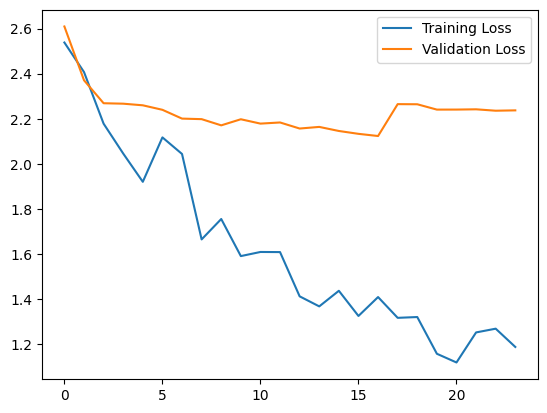

In [2]:
import torch
import tiktoken
import matplotlib.pyplot as plt
from datetime import datetime
from reasoning.dataset import get_dataloaders
from reasoning.model import OpenAICompatibleGPTModel, OPENAI_GPT_2_CFG_355M

def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)

    logits = model(input_batch)

    logits_flat = logits.view(-1, logits.size(-1))
    targets_flat = target_batch.view(-1)

    loss = torch.nn.functional.cross_entropy(
        logits_flat, targets_flat, ignore_index=-100
    )

    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    num_batches_processed = 0

    model.eval()

    with torch.no_grad():
        for i, (input_batch, attention_mask, target_batch) in enumerate(data_loader):
            if num_batches is not None and i >= num_batches:
                break

            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
            num_batches_processed += 1

    model.train()
    return total_loss / num_batches_processed if num_batches_processed > 0 else 0.

def train_model(
    model, train_loader, val_loader, optimizer, device,
    num_epochs, eval_freq, eval_iter, save_path="gpt_reasoning.pth"
):

    model.train()

    total_steps = len(train_loader) * num_epochs
    warmup_steps = total_steps // 10  # 10% warmup

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=5e-5,
        total_steps=total_steps,
        pct_start=0.1,  # 10% warmup
        anneal_strategy='cos'
    )

    global_step = 0
    best_val_loss = float('inf')

    train_losses, val_losses = [], []

    for epoch in range(num_epochs):
        for input_batch, attention_mask, target_batch in train_loader:
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            if not torch.isfinite(loss):
                print(f"WARNING: Invalid loss at step {global_step}: {loss.item()}")
                print(f"Batch shape: {input_batch.shape}")
                print(f"Skipping batch...")
                continue

            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            if global_step % eval_freq == 0:
                train_loss = calc_loss_loader(
                    train_loader, model, device, num_batches=eval_iter
                )

                val_loss = calc_loss_loader(
                    val_loader, model, device, num_batches=eval_iter
                )

                print(
                    f"Epoch {epoch + 1}, Step {global_step}: "
                    f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}"
                )

                train_losses.append(train_loss)
                val_losses.append(val_loss)

                # Save only best model
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(model.state_dict(), save_path)
                    print(f"Saved best model with val loss: {val_loss:.4f}")

            global_step += 1

    print("Training complete.")
    return train_losses, val_losses

def main():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        raise RuntimeError("CUDA Device not found.")

    print(f"Initial GPU memory allocated: {torch.cuda.memory_allocated()/1e9:.2f} GB")
    print(f"Initial GPU memory reserved: {torch.cuda.memory_reserved()/1e9:.2f} GB")

    tokenizer = tiktoken.get_encoding('gpt2')

    model = OpenAICompatibleGPTModel(OPENAI_GPT_2_CFG_355M).to(device)
    model.load_state_dict(torch.load("/content/drive/MyDrive/gpt2_355m_compat_openai.pth", map_location=device))

    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

    train_loader, _, val_loader = get_dataloaders(device=device, tokenizer=tokenizer, batch_size=1)

    train_losses, val_losses = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=device,
        num_epochs=3,
        eval_freq=100,
        eval_iter=10,
        save_path='/content/drive/MyDrive/gpt2_355m_reasonin_v1.pth'
    )

    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.legend(loc='upper right')

    plt.savefig(f"graphs/reasoning_finetuning_result_{datetime.now().isoformat().replace(':', '-')}.png")

if __name__ == "__main__":
    main()

In [14]:
import tiktoken
import torch
from reasoning.model import OpenAICompatibleGPTModel, OPENAI_GPT_2_CFG_355M

def text_to_token_ids(text: str, tokenizer: tiktoken.Encoding) -> torch.Tensor:
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids: torch.Tensor, tokenizer: tiktoken.Encoding) -> str:
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

def generate(
    model, idx: torch.Tensor, max_new_tokens: int, context_size: int,
    temperature: float=0.0, top_k: int | None=None, eos_id: torch.Tensor | None=None
) -> torch.Tensor:
    """ Generates next token via top-k samling + multinomial otherwise argmax. """
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]

        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        # Stop generating early if end-of-sequence token is encountered & specified
        # if idx_next == eos_id:
        #     break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx
device = 'cuda'
model = OpenAICompatibleGPTModel(OPENAI_GPT_2_CFG_355M).to(device)
model.load_state_dict(torch.load("/content/drive/MyDrive/gpt2_355m_reasonin_v1.pth", map_location=device))
model.eval()

tokenizer = tiktoken.get_encoding('gpt2')

prompt = "Could you provide an overview of freshman-level computer science fundamentals, ensuring to include a brief discussion on both hardware and software concepts?"

token_ids = generate(
    model=model,
    idx=text_to_token_ids(prompt, tokenizer).to(device),
    max_new_tokens=350,
    context_size=1024,
    top_k=25,
    temperature=0.7
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))



Output text:
 Could you provide an overview of freshman-level computer science fundamentals, ensuring to include a brief discussion on both hardware and software concepts?
Let's think step by step.
Okay, so I need to outline the basics of freshman-level computer science, including both hardware and software concepts. Let me start by breaking down what I know.

First, I remember that computer science focuses on the design algorithms and algorithms used in computing. So, maybe the basics are programming languages, registers, memory management, processors. But what about other aspects like data structures, memory management, data structures, etc?

Now, hardware is about the physical components like processors, memory, storage, storage devices. Hardware also includes data structures like arrays or sets. So, maybe the fundamentals in hardware are algorithms, data structures, data formats, etc.

Wait, I should mention other areas too. For example, data analysis, data manipulation, data stora

Output text:
 If I have 3 Apples and I ate 2, how many are left? If I have 5 Apples and I ate 2, how many are left?
Let's think step by step.
Okay, so I need to find the number of Apples left after I have 3 Apples and I ate 2. Let me start by recalling what the Apple problem states. The question is asking me to calculate how many Apples are left after I have 3 apples and I ate 2. Hmm, I remember that the number of Apples in an apple is 1 + 2

Output text:
 If I have 3 Apples and I ate 2, how many are left?

2

Answer: I have 2 Apples left.

Let me think of a more precise example. Suppose I have 2 Apples and I have 3 Cider Vinegars. If I have 3 Cider Vinegars, how many more Apples are there?

Let's see. If I have 2 Apples and have 3 Cider Vinegars, the question might be asking how many more apples are there. The answer is 2. So the formula for the number of Apples left is 2. Therefore, there are 2 apples left.

But wait, the user is asking how many apples are left, not how many apples are in the container. So in this case, I can't just subtract apples from 1 to get the total amount of apples. The total amount of apples would be 2. But in the case of two apples, the total amount could be 2 apples divided by 2. But if I divide by 3, the answer is 2. So the answer is 2.

But maybe I should clarify that 2 apples are left. So the total amount left is 2 apples. Wait, but in the case of two apples, the total amount is 2 apples divided by 2. But in this case, the quantity is 2 apples. But in the case of two apples, the total quantity is 2 apples. But in the case of two apples, the total amount is 2 apples. But in the case of two apples, the total amount

Output text:
 Determine the derivative of 2x^2 + 3x with respect to x.

The derivative of 2x^2 + 3x with respect to x is 2x - 3x, where x is the derivative of 2x with respect to x.

The derivative of 2x^2 + 3x with respect to x is 2x + 3x.

The derivative of 2x^2 + 3x with respect to x is 2x - 3x.

Given that the derivative of 2x with respect to x is 2x + 3x, then the derivative of 2x with respect to x can be found using the formula:

d² + (2x - 3x)(d² + 2x)

Now, we need to find the derivative of 2x with respect to x.

The derivative of 2x with respect to x is 2x - 3x.

Let me set aside the derivative of 2x with respect to x and check if it's even.

The derivative of 2x with respect to x is 2x - 3x.

If both sides of the equation are equal to zero, then the derivative of 2x with respect to x is zero.

But if the derivative of 2x with respect to x is 2x - 3x, then the derivative of 2x with respect to x is zero.

Therefore, the derivative of 2x with respect to x is 2x - 3x.

Let me check if the derivative of 2x with respect to x is positive.

The derivative of 2x with respect to x is 2x - 3x.

The derivative of 2x with respect to x is 2x + 3x.

The derivative of 2x + 3x is 2x - 3x.

Therefore, the derivative of 2x with respect to x is (2x - 3x)((2x - 3x)(2x + 3x) ).

Output text:
 Could you provide an overview of freshman-level computer science fundamentals, ensuring to include a brief discussion on both hardware and software concepts?
Let's think step by step.
Okay, so I need to outline the basics of freshman-level computer science, including both hardware and software concepts. Let me start by breaking down what I know.

First, I remember that computer science focuses on the design algorithms and algorithms used in computing. So, maybe the basics are programming languages, registers, memory management, processors. But what about other aspects like data structures, memory management, data structures, etc?

Now, hardware is about the physical components like processors, memory, storage, storage devices. Hardware also includes data structures like arrays or sets. So, maybe the fundamentals in hardware are algorithms, data structures, data formats, etc.

Wait, I should mention other areas too. For example, data analysis, data manipulation, data storage. Also, maybe the application programming interfaces (API) for programming languages like Python or Java.

Data structures are used for storing data. Maybe in data structures, like lists, dictionaries, stacks. For storing data, maybe in arrays or stacks. For data manipulation, maybe in algorithms like sorting, searching, etc.

Memory management is another area. Maybe in memory management, like how to manage memory efficiently. For example, using registers to store data, using locks in memory to access data efficiently.

Data formats are used for data storage. For data formats, like text, binary, octets, something else. For data storage, maybe in stacks, or in memory.

In software, algorithms come into play. For algorithms, data structures and algorithms, maybe in data structures themselves. For algorithms, possibly in some data structures like binary trees, or in some data structures like stacks.